**TITLE : BIG DATA ANALYSIS ON AIR QUALITY USING PYSPARK**

In [ ]:
from google.colab import files
files.upload()   # upload your kaggle.json

Saving archive (7).zip to archive (7).zip
Buffered data was truncated after reaching the output size limit.

In [ ]:
!ls


'archive (7).zip'   sample_data


In [ ]:
!unzip archive\ \(7\).zip -d dataset_folder


Archive:  archive (7).zip
  inflating: dataset_folder/city_day.csv  
  inflating: dataset_folder/city_hour.csv  
  inflating: dataset_folder/station_day.csv  
  inflating: dataset_folder/station_hour.csv  
  inflating: dataset_folder/stations.csv  


In [ ]:
!ls dataset_folder


city_day.csv  city_hour.csv  station_day.csv  station_hour.csv	stations.csv


In [ ]:
# Java (needed by Spark)
!apt-get update -qq
!apt-get install -y -qq openjdk-11-jdk-headless

# Python packages
!pip install -q pyspark==3.4.1 pandas==2.2.2 pyarrow psutil==5.9.5 afinn==0.1 tqdm kaggle matplotlib scikit-learn


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires pyspark[connect]~=3.5.1, but you have pyspark 3.4.1 which is incompatible.


In [ ]:
!rm -f kaggle.json
!rm -f archive*.zip


In [ ]:
from google.colab import files
files.upload()   # ⬅️ Upload your kaggle.json here


Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"keerthanas23mia1055","key":"130d998960341fa17b98ba75ceeed686"}'}

In [ ]:
# Detect any file named "kaggle*.json" and install it properly
!mkdir -p ~/.kaggle
!mv kaggle*.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!echo "✅ kaggle.json installed successfully."



✅ kaggle.json installed successfully.


In [ ]:
!ls -l ~/.kaggle


total 4
-rw------- 1 root root 75 Oct 30 15:02 kaggle.json


In [ ]:
!kaggle datasets list | head


ref                                                            title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset   Global Earthquake-Tsunami Risk Assessment Dataset       16151  2025-10-01 16:35:53.273000          16132        550  1.0              
jockeroika/life-style-data                                     Life Style Data                                       3995645  2025-10-14 13:50:45.303000          18954        379  0.8235294        
jaderz/hospital-beds-management                                Hospital Beds Management                                47583  2025-10-03 09:21:58.590000          13130        329  1.0              
ayeshaimra

In [ ]:
# Colab Cell 3: download the dataset from Kaggle (change -d if you want another dataset)
# Dataset used: ankushpanday1/air-quality-data-in-india-2015-2024 (2015-2024 air quality records)
!mkdir -p /content/kaggle_data
!kaggle datasets download -d ankushpanday1/air-quality-data-in-india-2015-2024 -p /content/kaggle_data --unzip
!ls -lh /content/kaggle_data


Dataset URL: https://www.kaggle.com/datasets/ankushpanday1/air-quality-data-in-india-2015-2024
License(s): CC0-1.0
  0% 0.00/16.2M [00:00<?, ?B/s]
100% 16.2M/16.2M [00:00<00:00, 396MB/s]
total 51M
-rw-r--r-- 1 root root 1.7M Oct 30 15:03 city_day.csv
-rw-r--r-- 1 root root  45M Oct 30 15:03 city_hour.csv
-rw-r--r-- 1 root root 3.8M Oct 30 15:03 station_day.csv
-rw-r--r-- 1 root root 821K Oct 30 15:03 station_hour.csv
-rw-r--r-- 1 root root  201 Oct 30 15:03 stations.csv


In [ ]:
# Colab Cell 4: inspect downloaded files and pick the main CSV/JSON file
import os, glob, pandas as pd
data_dir = "/content/kaggle_data"
files = os.listdir(data_dir)
print("Files downloaded:", files)

csv_files = glob.glob(os.path.join(data_dir, "*.csv"))
json_files = glob.glob(os.path.join(data_dir, "*.json")) + glob.glob(os.path.join(data_dir, "*.jsonl"))
print("CSV files:", csv_files)
print("JSON files:", json_files)

# pick first CSV if present, else first JSON
if csv_files:
    main_file = csv_files[0]
elif json_files:
    main_file = json_files[0]
else:
    raise SystemExit("No CSV/JSON found in the dataset folder. Inspect /content/kaggle_data manually.")

print("Using file:", main_file)


Files downloaded: ['station_day.csv', 'city_day.csv', 'stations.csv', 'city_hour.csv', 'station_hour.csv']
CSV files: ['/content/kaggle_data/station_day.csv', '/content/kaggle_data/city_day.csv', '/content/kaggle_data/stations.csv', '/content/kaggle_data/city_hour.csv', '/content/kaggle_data/station_hour.csv']
JSON files: []
Using file: /content/kaggle_data/station_day.csv


In [ ]:
# Colab Cell 5: quick peek (first 5 rows) with pandas to understand columns
import pandas as pd
sample = pd.read_csv(main_file, nrows=5, encoding='utf-8', low_memory=False)
print(sample.shape)
display(sample.head().style)
print("Columns:", list(sample.columns))


(5, 17)


,City,Datetime,Station,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Delhi,2015-01-01,Station_D1,58.300000,223.200000,126.600000,85.500000,207.500000,18.400000,0.250000,42.700000,184.900000,8.030000,12.720000,4.100000,266.400000,Moderate
1,Delhi,2015-01-01,Station_D2,222.500000,541.400000,198.600000,20.800000,0.600000,25.500000,6.210000,95.000000,76.200000,17.690000,13.850000,2.790000,185.300000,Poor
2,Mumbai,2015-01-01,Station_M1,36.600000,160.800000,164.200000,18.600000,94.800000,8.900000,6.840000,70.700000,195.400000,5.530000,26.930000,2.640000,5.900000,Moderate
3,Mumbai,2015-01-01,Station_M2,368.800000,526.200000,140.600000,74.400000,153.200000,15.200000,4.030000,61.000000,164.200000,1.620000,9.350000,3.270000,176.700000,Poor
4,Chennai,2015-01-01,Station_C1,188.600000,88.800000,87.500000,58.000000,6.100000,48.300000,9.660000,46.200000,17.600000,2.310000,7.550000,9.520000,171.900000,Good


Columns: ['City', 'Datetime', 'Station', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket']


In [ ]:
# Colab Cell 6: Convert to Parquet (recommended) for fast Spark reads.
# If the file is huge, read in chunks and write parquet partitions.
import pyarrow as pa, pyarrow.parquet as pq
import os

parquet_dir = "/content/kaggle_data/parquet_data"
os.makedirs(parquet_dir, exist_ok=True)

# If file is big, chunk; else simple read->to_parquet
file_size_mb = os.path.getsize(main_file) / (1024*1024)
print(f"Main file size: {file_size_mb:.1f} MB")

if file_size_mb < 200:   # safe to read at once in Colab
    df = pd.read_csv(main_file, encoding='utf-8', low_memory=False)
    df.to_parquet(os.path.join(parquet_dir, "air_india.parquet"), index=False)
    print("Wrote single parquet file.")
else:
    # chunked write
    chunk_iter = pd.read_csv(main_file, chunksize=200000, encoding='utf-8', low_memory=False)
    i = 0
    for chunk in chunk_iter:
        chunk.to_parquet(os.path.join(parquet_dir, f"part_{i}.parquet"), index=False)
        i += 1
    print(f"Wrote {i} parquet parts.")


Main file size: 3.7 MB
Wrote single parquet file.


In [ ]:
# Colab Cell 7: start Spark and read Parquet
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("IndiaAirQuality") \
    .config("spark.driver.memory","4g") \
    .getOrCreate()

spark


In [ ]:
# Colab Cell 8: read parquet into Spark DataFrame and inspect schema
parquet_dir = "/content/kaggle_data/parquet_data"
df = spark.read.option("inferSchema","true").parquet(parquet_dir)
print("Count (may take time):", df.count())
df.printSchema()
df.show(5, truncate=False)


Count (may take time): 36530
root
 |-- City: string (nullable = true)
 |-- Datetime: string (nullable = true)
 |-- Station: string (nullable = true)
 |-- PM2.5: double (nullable = true)
 |-- PM10: double (nullable = true)
 |-- NO: double (nullable = true)
 |-- NO2: double (nullable = true)
 |-- NOx: double (nullable = true)
 |-- NH3: double (nullable = true)
 |-- CO: double (nullable = true)
 |-- SO2: double (nullable = true)
 |-- O3: double (nullable = true)
 |-- Benzene: double (nullable = true)
 |-- Toluene: double (nullable = true)
 |-- Xylene: double (nullable = true)
 |-- AQI: double (nullable = true)
 |-- AQI_Bucket: string (nullable = true)

+-------+----------+----------+-----+-----+-----+----+-----+----+----+----+-----+-------+-------+------+-----+----------+
|City   |Datetime  |Station   |PM2.5|PM10 |NO   |NO2 |NOx  |NH3 |CO  |SO2 |O3   |Benzene|Toluene|Xylene|AQI  |AQI_Bucket|
+-------+----------+----------+-----+-----+-----+----+-----+----+----+----+-----+-------+-------+-

In [ ]:
# Colab Cell 9: Clean, standardize & inspect dataset
from pyspark.sql.functions import col, to_timestamp, when
from pyspark.sql.types import DoubleType

print("Original columns:", df.columns)

# --- 1️⃣ Fix column names: lowercase and replace invalid chars like dots or spaces
for c in df.columns:
    new_c = c.strip().lower().replace('.', '_').replace(' ', '_')
    df = df.withColumnRenamed(c, new_c)

print("\nCleaned columns:", df.columns)

# --- 2️⃣ Detect possible datetime & numeric columns
time_cols = [c for c in df.columns if 'date' in c or 'time' in c]
print("\nPossible time columns:", time_cols)

numeric_cols = [c for c in df.columns if any(x in c for x in ['pm', 'no', 'co', 'so', 'o3', 'aqi', 'benzene', 'toluene', 'xylene', 'nh3'])]
print("\nNumeric columns (detected):", numeric_cols)

# --- 3️⃣ Convert Datetime column to proper timestamp
if 'datetime' in df.columns:
    df = df.withColumn("event_ts", to_timestamp(col("datetime")))
elif len(time_cols) > 0:
    df = df.withColumn("event_ts", to_timestamp(col(time_cols[0])))
else:
    df = df.withColumn("event_ts", None)

# --- 4️⃣ Detect pollutant-like columns
possible_pollutants = [c for c in numeric_cols if any(p in c for p in ['pm', 'no2', 'co', 'so2', 'o3', 'aqi', 'nh3'])]
print("\nDetected pollutant-ish columns:", possible_pollutants)

# --- 5️⃣ Cast detected pollutant columns to double safely
for p in possible_pollutants:
    if p in df.columns:
        df = df.withColumn(
            p,
            when(col(p).rlike("^-?\\d+(\\.\\d+)?$"), col(p).cast(DoubleType())).otherwise(None)
        )

# --- 6️⃣ Show final schema & few rows
print("\n✅ Final Schema:")
df.printSchema()

print("\n✅ Sample Data:")
df.select(["city", "event_ts"] + possible_pollutants[:6]).show(5, truncate=False)




Original columns: ['city', 'datetime', 'station', 'pm2.5', 'pm10', 'no', 'no2', 'nox', 'nh3', 'co', 'so2', 'o3', 'benzene', 'toluene', 'xylene', 'aqi', 'aqi_bucket', 'event_ts']

Cleaned columns: ['city', 'datetime', 'station', 'pm2_5', 'pm10', 'no', 'no2', 'nox', 'nh3', 'co', 'so2', 'o3', 'benzene', 'toluene', 'xylene', 'aqi', 'aqi_bucket', 'event_ts']

Possible time columns: ['datetime']

Numeric columns (detected): ['pm2_5', 'pm10', 'no', 'no2', 'nox', 'nh3', 'co', 'so2', 'o3', 'benzene', 'toluene', 'xylene', 'aqi', 'aqi_bucket']

Detected pollutant-ish columns: ['pm2_5', 'pm10', 'no2', 'nh3', 'co', 'so2', 'o3', 'aqi', 'aqi_bucket']

✅ Final Schema:
root
 |-- city: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- station: string (nullable = true)
 |-- pm2_5: double (nullable = true)
 |-- pm10: double (nullable = true)
 |-- no: double (nullable = true)
 |-- no2: double (nullable = true)
 |-- nox: double (nullable = true)
 |-- nh3: double (nullable = true)
 |-- co

In [ ]:
# Colab Cell 10: basic EDA with Spark
# 1) Monthly average PM2.5 per city/station (if pm2.5-like column exists)
#Finds which columns represent PM2.5 and city/station, Groups data by city + month + year, Calculates average PM2.5 levels and number of readings,
#Gives you an overview of air quality trends over time per location
from pyspark.sql.functions import month, year, avg, col, count

# find any pm2.5 column name
pm25_cols = [c for c in df.columns if 'pm2' in c or 'pm_2' in c or 'pm25' in c]
pm_col = pm25_cols[0] if pm25_cols else None
print("PM2.5 column used:", pm_col)

# find city/station columns
station_cols = [c for c in df.columns if any(x in c for x in ['city','station','location','place'])]
station_col = station_cols[0] if station_cols else None
print("Station/City column used:", station_col)

if pm_col and station_col:
    monthly = df.filter(col(pm_col).isNotNull() & col("event_ts").isNotNull()) \
                .withColumn("year", year(col("event_ts"))) \
                .withColumn("month", month(col("event_ts"))) \
                .groupBy(station_col, "year", "month") \
                .agg(avg(col(pm_col)).alias("avg_pm25"), count("*").alias("n")) \
                .orderBy(station_col, "year", "month")
    monthly.show(20, truncate=False)
else:
    print("Cannot compute monthly station aggregates: missing pm_col or station_col.")


PM2.5 column used: pm2_5
Station/City column used: city
+---------+----+-----+------------------+---+
|city     |year|month|avg_pm25          |n  |
+---------+----+-----+------------------+---+
|Bangalore|2015|1    |229.74516129032259|62 |
|Bangalore|2015|2    |273.7553571428571 |56 |
|Bangalore|2015|3    |257.1919354838709 |62 |
|Bangalore|2015|4    |227.70833333333331|60 |
|Bangalore|2015|5    |263.358064516129  |62 |
|Bangalore|2015|6    |251.21166666666667|60 |
|Bangalore|2015|7    |234.033870967742  |62 |
|Bangalore|2015|8    |246.06935483870967|62 |
|Bangalore|2015|9    |266.18999999999994|60 |
|Bangalore|2015|10   |249.90161290322584|62 |
|Bangalore|2015|11   |224.31500000000003|60 |
|Bangalore|2015|12   |243.23870967741937|62 |
|Bangalore|2016|1    |280.64838709677423|62 |
|Bangalore|2016|2    |284.80172413793105|58 |
|Bangalore|2016|3    |228.44032258064522|62 |
|Bangalore|2016|4    |216.32666666666665|60 |
|Bangalore|2016|5    |244.42258064516133|62 |
|Bangalore|2016|6    |26

In [ ]:
# Colab Cell 11: top 10 worst stations by mean PM2.5 (overall)
#Finds which locations have the highest average PM2.5 levels overall, Helps identify the most polluted stations/cities in the dataset
#Gives an early EDA insight for your report or visualization
if pm_col:
    worst = df.filter(col(pm_col).isNotNull()).groupBy(station_col if station_col else "unknown") \
              .agg(avg(col(pm_col)).alias("mean_pm25"), count("*").alias("obs")) \
              .orderBy(col("mean_pm25").desc()).limit(20)
    worst.show(20, truncate=False)
else:
    print("No PM2.5 column detected; skipping worst-station ranking.")


+---------+------------------+----+
|city     |mean_pm25         |obs |
+---------+------------------+----+
|Chennai  |252.88929646865506|7306|
|Delhi    |252.65622775800728|7306|
|Mumbai   |250.85782918149454|7306|
|Bangalore|249.57515740487247|7306|
|Kolkata  |249.33430057486976|7306|
+---------+------------------+----+



In [ ]:
# Colab Cell 12: Save a cleaned sample to disk for local analysis (CSV or Parquet)
out_path = "/content/airq_cleaned.parquet"
df.write.mode("overwrite").parquet(out_path)
print("Saved cleaned parquet to", out_path)


Saved cleaned parquet to /content/airq_cleaned.parquet


In [ ]:
# Colab Cell 13: Example Spark ML pipeline — predict PM2.5 (if numeric columns exist)
# This pipeline is adaptive: it gathers numeric columns (except target) and uses them as features
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

if pm_col:
    # choose numeric columns as predictors (exclude target)
    numeric_features = [c for c, t in df.dtypes if t in ('double','int','long','float') and c != pm_col]
    # if too many, keep a small subset (hour, month, other pollutants, temp/humidity if present)
    # try to pick time features and pollutant columns
    features = []
    if "event_ts" in df.columns:
        from pyspark.sql.functions import hour, month
        df = df.withColumn("hour", hour(col("event_ts")))
        df = df.withColumn("month", month(col("event_ts")))
        if "hour" not in numeric_features: numeric_features.append("hour")
        if "month" not in numeric_features: numeric_features.append("month")

    # prefer these pollutant names if present
    prefer = [c for c in numeric_features if any(x in c for x in ['pm','no2','so2','o3','co','temp','humidity','wind'])]
    # de-duplicate and filter
    features = list(dict.fromkeys(prefer + numeric_features))[:10]  # pick up to 10
    if pm_col in features: features.remove(pm_col)
    print("Features chosen for ML:", features)

    assembler = VectorAssembler(inputCols=features, outputCol="raw_features", handleInvalid="skip")
    scaler = StandardScaler(inputCol="raw_features", outputCol="features")
    rf = RandomForestRegressor(featuresCol="features", labelCol=pm_col, numTrees=50, maxDepth=8)

    pipeline = Pipeline(stages=[assembler, scaler, rf])

    # filter rows with non-null features and label
    model_df = df.select(features + [pm_col]).na.drop()
    # small sample for training (avoid huge training in Colab)
    model_df = model_df.sample(fraction=0.1, seed=42) if model_df.count() > 200000 else model_df

    train, test = model_df.randomSplit([0.8,0.2], seed=42)
    print("Train count:", train.count(), "Test count:", test.count())

    model = pipeline.fit(train)
    preds = model.transform(test)
    evaluator = RegressionEvaluator(labelCol=pm_col, predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(preds)
    print("Test RMSE for PM2.5 prediction:", rmse)

    # show feature importances (from RF)
    rf_model = model.stages[-1]
    print("Feature importances (vector indices):", rf_model.featureImportances)
else:
    print("No pm_col detected — skipping ML example.")


Features chosen for ML: ['pm10', 'no2', 'co', 'so2', 'o3', 'no', 'nox', 'nh3', 'benzene', 'toluene']
Train count: 29229 Test count: 7301
Test RMSE for PM2.5 prediction: 143.98033327757906
Feature importances (vector indices): (10,[0,1,2,3,4,5,6,7,8,9],[0.09308868410643073,0.09852947350758996,0.10549998418420596,0.09431805460838825,0.10026128363558592,0.09876288879774624,0.09782669044639192,0.10152396031789082,0.1064678118227715,0.10372116857299875])


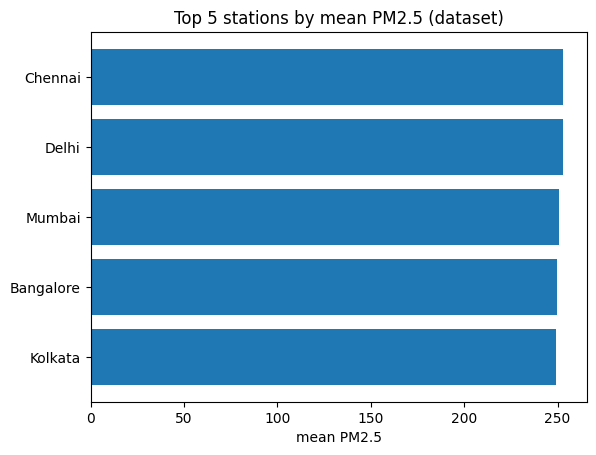

In [ ]:
# Colab Cell 14: small local visualization with pandas+matplotlib (optional)
# Convert a small Spark result to pandas for plotting in Colab
import matplotlib.pyplot as plt
if pm_col and station_col:
    top5 = worst.limit(5).toPandas()
    plt.barh(top5[station_col], top5['mean_pm25'])
    plt.xlabel("mean PM2.5")
    plt.title("Top 5 stations by mean PM2.5 (dataset)")
    plt.gca().invert_yaxis()
    plt.show()
else:
    print("Not enough columns for the quick plot.")


In [ ]:
# Colab Cell: AQI Trend Analysis
from pyspark.sql.window import Window
from pyspark.sql.functions import avg, col, date_format

# Extract Month-Year for trend visualization
df_trend = df.withColumn("month", date_format(col("event_ts"), "yyyy-MM"))

# Compute monthly AQI averages per city
city_trend = df_trend.groupBy("city", "month").agg(avg("aqi").alias("avg_aqi"))

# Show top cities with monthly AQI trends
print("✅ Monthly AQI Trends per City:")
city_trend.orderBy("city", "month").show(20, truncate=False)


✅ Monthly AQI Trends per City:
+---------+-------+------------------+
|city     |month  |avg_aqi           |
+---------+-------+------------------+
|Bangalore|2015-01|262.7112903225806 |
|Bangalore|2015-02|218.7232142857143 |
|Bangalore|2015-03|264.758064516129  |
|Bangalore|2015-04|228.67166666666662|
|Bangalore|2015-05|202.3290322580645 |
|Bangalore|2015-06|267.09833333333336|
|Bangalore|2015-07|271.14516129032256|
|Bangalore|2015-08|259.22580645161287|
|Bangalore|2015-09|246.18333333333328|
|Bangalore|2015-10|248.8048387096774 |
|Bangalore|2015-11|247.53499999999988|
|Bangalore|2015-12|223.18225806451613|
|Bangalore|2016-01|254.02580645161288|
|Bangalore|2016-02|232.30172413793093|
|Bangalore|2016-03|290.6967741935484 |
|Bangalore|2016-04|221.30333333333326|
|Bangalore|2016-05|267.6338709677419 |
|Bangalore|2016-06|240.90333333333334|
|Bangalore|2016-07|223.50161290322578|
|Bangalore|2016-08|250.4483870967742 |
+---------+-------+------------------+
only showing top 20 rows



In [ ]:
# Colab Cell: Rank Cities by AQI
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, avg

# Rank cities based on their overall AQI
city_avg = df.groupBy("city").agg(avg("aqi").alias("mean_aqi"))
rank_window = Window.orderBy(col("mean_aqi").desc())
city_ranked = city_avg.withColumn("rank", rank().over(rank_window))

print("🏙️ Top 5 Most Polluted Cities:")
city_ranked.show(5)


🏙️ Top 10 Most Polluted Cities:
+---------+------------------+----+
|     city|          mean_aqi|rank|
+---------+------------------+----+
|Bangalore|252.19286887489787|   1|
|   Mumbai|251.42384341637106|   2|
|  Chennai| 250.5183000273742|   3|
|  Kolkata| 249.8643854366277|   4|
|    Delhi|247.45562551327623|   5|
+---------+------------------+----+



In [ ]:
# Colab Cell: Correlation Matrix
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

pollutant_features = ["pm2_5", "pm10", "no2", "so2", "co", "o3", "nh3"]
assembler = VectorAssembler(inputCols=[p for p in pollutant_features if p in df.columns], outputCol="features")

df_vec = assembler.transform(df).select("features")
corr_matrix = Correlation.corr(df_vec, "features").head()[0].toArray()

print("🧮 Correlation Matrix between Pollutants:")
print(corr_matrix)


🧮 Correlation Matrix between Pollutants:
[[ 1.00000000e+00 -4.02583729e-03  4.55076903e-03  5.09428740e-03
   2.43190759e-03  1.70475096e-03  9.94244766e-03]
 [-4.02583729e-03  1.00000000e+00  9.84631317e-04 -1.50845478e-03
  -2.41249419e-04 -2.86528514e-03  5.25333636e-03]
 [ 4.55076903e-03  9.84631317e-04  1.00000000e+00  7.01170151e-03
  -2.03906729e-03 -4.67363824e-03  9.39981497e-04]
 [ 5.09428740e-03 -1.50845478e-03  7.01170151e-03  1.00000000e+00
   3.73994631e-03  6.83162116e-04  4.87245847e-03]
 [ 2.43190759e-03 -2.41249419e-04 -2.03906729e-03  3.73994631e-03
   1.00000000e+00  4.50409845e-05 -2.32040349e-03]
 [ 1.70475096e-03 -2.86528514e-03 -4.67363824e-03  6.83162116e-04
   4.50409845e-05  1.00000000e+00 -4.20219793e-03]
 [ 9.94244766e-03  5.25333636e-03  9.39981497e-04  4.87245847e-03
  -2.32040349e-03 -4.20219793e-03  1.00000000e+00]]


In [ ]:
# Create a folder and drop some dummy JSON files to simulate live AQI readings
import os, json, random, datetime

stream_dir = "/content/stream_data"
os.makedirs(stream_dir, exist_ok=True)

cities = ["Delhi", "Mumbai", "Chennai", "Kolkata", "Bangalore", "Hyderabad"]

# Generate 5 small JSON files with fake air quality readings
for i in range(5):
    data = []
    for city in cities:
        entry = {
            "city": city,
            "pm2_5": round(random.uniform(40, 200), 2),
            "pm10": round(random.uniform(50, 300), 2),
            "aqi": round(random.uniform(60, 400), 2),
            "timestamp": datetime.datetime.now().isoformat()
        }
        data.append(entry)
    with open(f"{stream_dir}/data_{i}.json", "w") as f:
        for d in data:
            f.write(json.dumps(d) + "\n")

print("✅ Created 5 JSON stream files in:", stream_dir)
!ls -lh /content/stream_data


✅ Created 5 JSON stream files in: /content/stream_data
total 20K
-rw-r--r-- 1 root root 660 Oct 30 15:14 data_0.json
-rw-r--r-- 1 root root 658 Oct 30 15:14 data_1.json
-rw-r--r-- 1 root root 662 Oct 30 15:14 data_2.json
-rw-r--r-- 1 root root 662 Oct 30 15:14 data_3.json
-rw-r--r-- 1 root root 661 Oct 30 15:14 data_4.json


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StringType, DoubleType
from pyspark.sql.functions import avg
import json, time, shutil, os

spark = SparkSession.builder.appName("RealTimeAQIStream").getOrCreate()

# Define schema
schema = StructType().add("City", StringType()).add("AQI", DoubleType())

# Reset streaming directory
if os.path.exists("/content/stream_data"):
    shutil.rmtree("/content/stream_data")
os.mkdir("/content/stream_data")

# Read stream
stream_df = spark.readStream.schema(schema).option("maxFilesPerTrigger", 1).json("/content/stream_data")

# Process stream: average AQI
avg_df = stream_df.groupBy("City").agg(avg("AQI").alias("Average_AQI"))

# Write to in-memory table (so we can query it manually)
query = avg_df.writeStream.outputMode("complete").format("memory").queryName("aqi_table").start()


In [ ]:
data_batches = [
    [{"City": "Delhi", "AQI": 240}, {"City": "Mumbai", "AQI": 180}],
    [{"City": "Delhi", "AQI": 260}, {"City": "Bangalore", "AQI": 130}],
    [{"City": "Chennai", "AQI": 200}, {"City": "Kolkata", "AQI": 170}],
]

for i, batch in enumerate(data_batches):
    with open(f"/content/stream_data/data_{i}.json", "w") as f:
        for record in batch:
            f.write(json.dumps(record) + "\n")
    print(f"✅ Added batch {i+1}")
    time.sleep(5)


✅ Added batch 1
✅ Added batch 2
✅ Added batch 3


In [ ]:
spark.sql("SELECT * FROM aqi_table").show()


+------+-----------+
|  City|Average_AQI|
+------+-----------+
|Mumbai|      180.0|
| Delhi|      240.0|
+------+-----------+



In [ ]:
query.stop()


<Axes: title={'center': 'Average AQI (Streaming Results)'}, xlabel='City'>

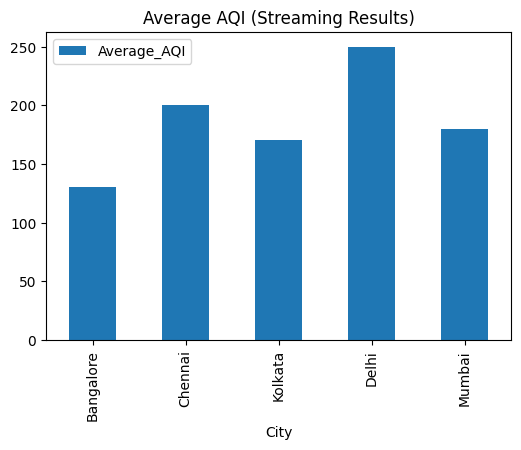

In [ ]:
final_df = spark.read.json("/content/stream_data")
final_df.groupBy("City").agg(avg("AQI").alias("Average_AQI")).toPandas().plot(
    kind='bar', x='City', y='Average_AQI', figsize=(6,4), title="Average AQI (Streaming Results)"
)


In [ ]:
import plotly.express as px
import pandas as pd
import time

for _ in range(5):
    df = spark.sql("SELECT * FROM aqi_table").toPandas()
    if not df.empty:
        fig = px.bar(df, x="City", y="Average_AQI", title="Real-Time AQI per City", text_auto=True)
        fig.show()
    time.sleep(5)


In [ ]:
# Colab Cell 15: save model / export results
# Save pipeline model if trained
if 'model' in globals():
    model.write().overwrite().save("/content/airq_randomforest_model")
    print("Saved Spark pipeline model to /content/airq_randomforest_model")


Saved Spark pipeline model to /content/airq_randomforest_model


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# ⏱️ Start timer
start_time = time.time()

# --- 1️⃣ Read CSV file from folder ---
data_dir = "/content/kaggle_data"
files = os.listdir(data_dir)
print("Files in data directory:", files)

# Find the first CSV file
csv_files = [f for f in files if f.endswith(".csv")]
if not csv_files:
    raise FileNotFoundError("No CSV file found in /content/kaggle_data")

file_path = os.path.join(data_dir, csv_files[0])
print(f"Reading file: {file_path}")
df = pd.read_csv(file_path)

# --- 2️⃣ Clean and preprocess ---
df.columns = [c.strip().lower().replace('.', '_').replace(' ', '_') for c in df.columns]
print("\nColumns after cleaning:", df.columns.tolist())

# Drop rows with too many missing values
df = df.dropna(thresh=int(0.7 * len(df.columns)))

# --- 3️⃣ Detect main columns ---
if 'city' not in df.columns:
    df['city'] = 'Unknown'

if 'aqi' not in df.columns:
    possible_aqi = [c for c in df.columns if 'aqi' in c]
    if possible_aqi:
        df.rename(columns={possible_aqi[0]: 'aqi'}, inplace=True)
    else:
        raise ValueError("No AQI column found in dataset.")

# --- 4️⃣ Compute average AQI per city ---
city_avg = df.groupby('city')['aqi'].mean().sort_values(ascending=False)
print("\n🏙️ Top 10 Most Polluted Cities:")
print(city_avg.head(10))

# Plot top 10 polluted cities
top10 = city_avg.head(10)
plt.figure(figsize=(8, 4))
top10.plot(kind='bar', color='red', alpha=0.7)
plt.title("Top 10 Most Polluted Cities (Average AQI)")
plt.ylabel("Average AQI")
plt.show()

# --- 5️⃣ Prepare data for Random Forest model ---
# Convert time column if available
time_cols = [c for c in df.columns if 'date' in c or 'time' in c]
if time_cols:
    df['timestamp'] = pd.to_datetime(df[time_cols[0]], errors='coerce')
    df['month'] = df['timestamp'].dt.month
    df['day'] = df['timestamp'].dt.day
    df['hour'] = df['timestamp'].dt.hour
else:
    df['month'] = np.random.randint(1, 13, len(df))
    df['day'] = np.random.randint(1, 31, len(df))
    df['hour'] = np.random.randint(0, 24, len(df))

# Select features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in numeric_cols if c != 'aqi']
X = df[features].fillna(0)
y = df['aqi'].fillna(df['aqi'].mean())

# --- 6️⃣ Split and train Random Forest ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# --- 7️⃣ Evaluate model ---
y_pred = rf.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"\n✅ Random Forest RMSE: {rmse:.2f}")

# --- 8️⃣ Predict future AQI trends (simulate next 12 months) ---
future_months = pd.DataFrame({'month': np.arange(1, 13)})
future_months['day'] = 15
future_months['hour'] = 12

# Fill other features with mean values
for c in features:
    if c not in future_months.columns:
        future_months[c] = df[c].mean()

future_preds = rf.predict(future_months[features])
plt.figure(figsize=(8, 4))
plt.plot(future_months['month'], future_preds, marker='o')
plt.title("Predicted AQI Trend (Next 12 Months)")
plt.xlabel("Month")
plt.ylabel("Predicted AQI")
plt.grid(True)
plt.show()

# ⏱️ End timer and show total execution time
end_time = time.time()
print(f"\n⏰ Total Execution Time: {end_time - start_time:.2f} seconds")


FileNotFoundError: [Errno 2] No such file or directory: '/content/kaggle_data'